In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_australian_credit_approval = fetch_ucirepo(id=143)

# data (as pandas dataframes)
X = statlog_australian_credit_approval.data.features
y = statlog_australian_credit_approval.data.targets

# metadata
print(statlog_australian_credit_approval.metadata)

# variable information
print(statlog_australian_credit_approval.variables)


{'uci_id': 143, 'name': 'Statlog (Australian Credit Approval)', 'repository_url': 'https://archive.ics.uci.edu/dataset/143/statlog+australian+credit+approval', 'data_url': 'https://archive.ics.uci.edu/static/public/143/data.csv', 'abstract': 'This file concerns credit card applications. This database exists elsewhere in the repository (Credit Screening Database) in a slightly different form', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 690, 'num_features': 14, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['A15'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1987, 'last_updated': None, 'dataset_doi': '10.24432/C59012', 'creators': ['Ross Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect 

In [ ]:
print(X.head())  #特征是否有缺失值？特征是否需要做编码（如类别型变量是否已转为数值）？标签是 0/1 吗？是否平衡？
print(X.info())
print(y.value_counts())


   A1     A2     A3  A4  A5  A6     A7  A8  A9  A10  A11  A12  A13   A14
0   1  22.08  11.46   2   4   4  1.585   0   0    0    1    2  100  1213
1   0  22.67   7.00   2   8   4  0.165   0   0    0    0    2  160     1
2   0  29.58   1.75   1   4   4  1.250   0   0    0    1    2  280     1
3   0  21.67  11.50   1   5   3  0.000   1   1   11    1    2    0     1
4   1  20.17   8.17   2   6   4  1.960   1   1   14    0    2   60   159
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    int64  
 1   A2      690 non-null    float64
 2   A3      690 non-null    float64
 3   A4      690 non-null    int64  
 4   A5      690 non-null    int64  
 5   A6      690 non-null    int64  
 6   A7      690 non-null    float64
 7   A8      690 non-null    int64  
 8   A9      690 non-null    int64  
 9   A10     690 non-null    int64  
 10  A11     

✅ Selected Features:
 ['A2', 'A3', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A14']


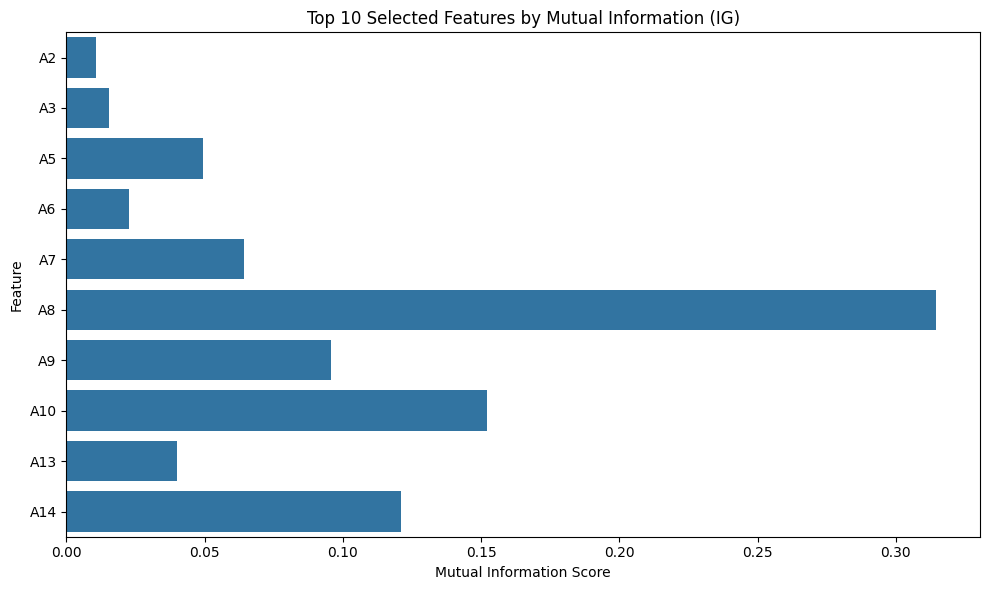


📊 Confusion Matrix:
 [[75 12]
 [10 41]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87        87
           1       0.77      0.80      0.79        51

    accuracy                           0.84       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.84      0.84      0.84       138

✅ Accuracy: 0.8405797101449275
✅ 模型已保存为 'stacked_credit_model.pkl'
✅ 加载后的模型准确率: 0.8405797101449275


In [ ]:
# ===== 2. 导入库 =====
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ===== 3. 加载数据集 =====
data = fetch_ucirepo(id=143)
X = data.data.features.copy()
y = data.data.targets.values.ravel()

# ===== 4. 编码类别变量 =====
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

# ===== 5. 特征选择：信息增益（IG） =====
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]
print("✅ Selected Features:\n", selected_features.tolist())

# ===== 6. 可视化特征重要性 =====
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_scores, y=selected_features)
plt.title("Top 10 Selected Features by Mutual Information (IG)")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ===== 7. 拆分训练和测试集 =====
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# ===== 8. 构建 Stacking 模型 =====
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]
meta_learner = LogisticRegression()

stack_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
stack_model.fit(X_train, y_train)

# ===== 9. 模型评估 =====
y_pred = stack_model.predict(X_test)

print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# ===== 10. 模型保存与加载验证 =====
joblib.dump(stack_model, 'stacked_credit_model.pkl')
print("✅ 模型已保存为 'stacked_credit_model.pkl'")

loaded_model = joblib.load('stacked_credit_model.pkl')
print("✅ 加载后的模型准确率:", accuracy_score(y_test, loaded_model.predict(X_test)))

## 📊 模型评估分析

我们使用 Australian Credit 数据集构建了一个基于 `Stacked Classifier + Filter-Based Feature Selection` 的信用风险预测模型，并使用 80/20 划分方式进行训练与测试。模型的评估结果如下：

### ✅ 混淆矩阵
[[75 12]
[10 41]]

markdown
复制
编辑

- **True Negatives (TN)**：75 —— 成功识别为拒贷客户  
- **False Positives (FP)**：12 —— 错误地批准了应被拒绝的客户  
- **False Negatives (FN)**：10 —— 错误地拒绝了应被批准的客户  
- **True Positives (TP)**：41 —— 成功识别为可批准客户

### 📋 分类报告
| 指标      | 类别 0（拒贷） | 类别 1（批准） |
|-----------|----------------|----------------|
| 精度      | 0.88           | 0.77           |
| 召回率    | 0.86           | 0.80           |
| F1 分数   | 0.87           | 0.79           |

- **总体准确率**：`0.84`

### 🔍 关键分析

- 模型在区分信用良好与不良客户方面表现较好，尤其是对拒贷客户（类别 0）的识别能力更强（F1 = 0.87）。
- 对批准客户（类别 1）的预测略弱，可能由于数据分布不平衡所致。
- 可考虑应用 **SMOTE** 或 **CTGAN** 增强少数类别，提高类别 1 的识别能力。
- 从误分类成本角度，**误批准（FP）**带来的潜在信用风险更大，因此可结合业务策略适度提升精度。
- 后续拟使用 **SHAP 或 LIME** 分析模型预测依据，增强可解释性，并尝试更复杂的集成方法（如 CatBoost、AutoM

['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A14'], dtype='object')  需要给这些变量做一点insight，画出并说出含义